<a href="https://colab.research.google.com/github/alperkent/GIF-compression/blob/main/CMPE_544_final_project_AE_ON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 104kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install unzip
!wget -O BSR_bsds500.tgz http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
!tar -xvf  'BSR_bsds500.tgz' -C './'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 17 not upgraded.
--2021-02-16 18:27:18--  http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving www.eecs.berkeley.edu (www.eecs.berkeley.edu)... 23.185.0.1, 2620:12a:8000::1, 2620:12a:8001::1
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|23.185.0.1|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz [following]
--2021-02-16 18:27:18--  https://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Connecting to www.eecs.berkeley.edu (www.eecs.berkeley.edu)|23.185.0.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www2.eecs.berkeley.edu/Res

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


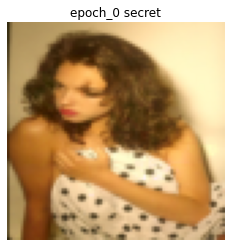

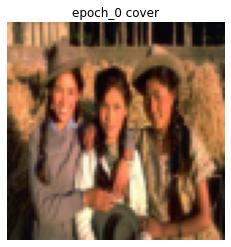

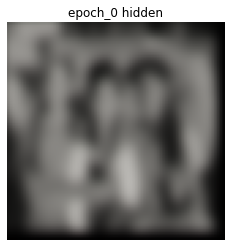

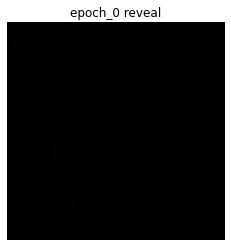


--------------------



In [ ]:
import tensorflow as tf
import numpy as np,sys,os
from numpy import float32
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scipy.ndimage import imread
from scipy.misc import imresize

np.random.seed(27)
tf.set_random_seed(27)

# Activation Functions
def tf_Relu(x): return tf.nn.relu(x)
def d_tf_Relu(x): return tf.cast(tf.greater(x,0),tf.float32)

def tf_log(x): return tf.sigmoid(x)
def d_tf_log(x): return tf_log(x) * (1.0 - tf.log(x))

def tf_tanh(x): return tf.tanh(x)
def d_tf_tanh(x): return 1.0 - tf.square(tf_tanh(x))

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    X = np.asarray(dict[b'data'].T).astype("uint8")
    Yraw = np.asarray(dict[b'labels'])
    Y = np.zeros((10,10000))
    for i in range(10000):
        Y[Yraw[i],i] = 1
    names = np.asarray(dict[b'filenames'])
    return X,Y,names

# make class 
class CNNLayer():
    
    def __init__(self,ker,in_c,out_c,act,d_act,):
        
        self.w = tf.Variable(tf.truncated_normal([ker,ker,in_c,out_c],stddev=0.005))
        self.act,self.d_act = act,d_act
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))

    def feedforward(self,input,stride=1):
        self.input  = input
        self.layer  = tf.nn.conv2d(input,self.w,strides = [1,stride,stride,1],padding='SAME')
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient,stride=1):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = tf.multiply(grad_part_1,grad_part_2)
        grad = tf.nn.conv2d_backprop_filter(
            input = grad_part_3,filter_sizes = self.w.shape,
            out_backprop = grad_middle,strides=[1,1,1,1], padding="SAME"
        )

        grad_pass  = tf.nn.conv2d_backprop_input(
            input_sizes=[batch_size] + list(self.input.shape[1:]),filter = self.w ,
            out_backprop = grad_middle,strides=[1,1,1,1], padding="SAME"
        )

        update_w = []

        update_w.append(
            tf.assign( self.m,self.m*beta_1 + (1-beta_1) * grad   )
        )
        update_w.append(
            tf.assign( self.v,self.v*beta_2 + (1-beta_2) * grad ** 2   )
        )

        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat))))

        return grad_pass,update_w

data_location = "./train/"
data_array = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in fileList:
        if ".jpg" in filename.lower():  # check whether the file's DICOM
            data_array.append(os.path.join(dirName,filename))

data_location = "./val/"
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in fileList:
        if ".jpg" in filename.lower():  # check whether the file's DICOM
            data_array.append(os.path.join(dirName,filename))

X = np.zeros(shape=(300,80,80,3))

for file_index in range(len(data_array)):
    X[file_index,:,:]   = imresize(imread(data_array[file_index],mode='RGB'),(80,80))

X = shuffle(X)

mins = []
for i in range(3):
    mins.append(X[:,:,:,i].min(axis=0))

maxes = []
for i in range(3):
    maxes.append(X[:,:,:,i].max(axis=0))

X[:,:,:,0] = (X[:,:,:,0]-mins[0])/(maxes[0]-mins[0])
X[:,:,:,1] = (X[:,:,:,1]-mins[1])/(maxes[1]-mins[1])
X[:,:,:,2] = (X[:,:,:,2]-mins[2])/(maxes[2]-mins[2])

half = len(X)//2
s_images = X[:half,:,:,:]
c_images = X[half:,:,:,:]

# hyper
num_epoch = 3000

learing_rate = 0.001
batch_size = 10

networ_beta = 0.75

beta_1,beta_2 = 0.9,0.999
adam_e = 1e-8

# init class
prep_net1 = CNNLayer(4,3,50,tf_Relu,d_tf_Relu)
prep_net2 = CNNLayer(4,50,50,tf_Relu,d_tf_Relu)
prep_net3 = CNNLayer(4,50,50,tf_Relu,d_tf_Relu)
prep_net4 = CNNLayer(2,50,30,tf_Relu,d_tf_Relu)
prep_net5 = CNNLayer(2,30,7,tf_tanh,d_tf_tanh)

hide_net1 = CNNLayer(4,10,50,tf_Relu,d_tf_Relu)
hide_net2 = CNNLayer(4,50,50,tf_Relu,d_tf_Relu)
hide_net3 = CNNLayer(4,50,50,tf_Relu,d_tf_Relu)
hide_net4 = CNNLayer(4,50,50,tf_Relu,d_tf_Relu)
hide_net5 = CNNLayer(2,50,30,tf_Relu,d_tf_Relu)
hide_net6 = CNNLayer(2,30,3,tf_tanh,d_tf_tanh)

reve_net1 = CNNLayer(4,3,100,tf_Relu,d_tf_Relu)
reve_net2 = CNNLayer(4,100,100,tf_Relu,d_tf_Relu)
reve_net3 = CNNLayer(4,100,50,tf_Relu,d_tf_Relu)
reve_net4 = CNNLayer(2,50,3,tf_tanh,d_tf_tanh)

# make graph
Secret = tf.placeholder(shape=[None,80,80,3],dtype=tf.float32)
Cover = tf.placeholder(shape=[None,80,80,3],dtype=tf.float32)

prep_layer1 = prep_net1.feedforward(Secret)
prep_layer2 = prep_net2.feedforward(prep_layer1)
prep_layer3 = prep_net3.feedforward(prep_layer2)
prep_layer4 = prep_net4.feedforward(prep_layer3)
prep_layer5 = prep_net5.feedforward(prep_layer4)

hide_Input = tf.concat([Cover,prep_layer5],axis=3)
hide_layer1 = hide_net1.feedforward(hide_Input)
hide_layer2 = hide_net2.feedforward(hide_layer1)
hide_layer3 = hide_net3.feedforward(hide_layer2)
hide_layer4 = hide_net4.feedforward(hide_layer3)
hide_layer5 = hide_net5.feedforward(hide_layer4)
hide_layer6 = hide_net6.feedforward(hide_layer5)

reve_layer1 = reve_net1.feedforward(hide_layer6)
reve_layer2 = reve_net2.feedforward(reve_layer1)
reve_layer3 = reve_net3.feedforward(reve_layer2)
reve_layer4 = reve_net4.feedforward(reve_layer3)

cost_1 = tf.reduce_mean(tf.square(hide_layer6 - Cover))*0.5
cost_2 = tf.reduce_mean(tf.square(reve_layer4 - Secret))*0.5*networ_beta

# --- auto train ---
auto_train = tf.train.AdamOptimizer(learning_rate=learing_rate).minimize(cost_1+cost_2)

# gets error
def get_error(secret, cover, hidden, reveal):
    secret_diff = np.sum(abs(secret - reveal))
    cover_diff = np.sum(abs(cover - hidden))
    return secret_diff/80/80/3, cover_diff/80/80/3

# start the session
with tf.Session() as sess : 

    sess.run(tf.global_variables_initializer())
    costs = np.zeros((num_epoch, len(s_images)//batch_size, 2))
    error = np.zeros((num_epoch//100, len(s_images), 2))

    for iter in range(num_epoch):
        for current_batch_index in range(0,len(s_images),batch_size):
            current_batch_s = s_images[current_batch_index:current_batch_index+batch_size,:,:,:]
            current_batch_c = c_images[current_batch_index:current_batch_index+batch_size,:,:,:]
            sess_results = sess.run([cost_1,cost_2,auto_train],feed_dict={Secret:current_batch_s,Cover:current_batch_c})
            #print("Iter: ",iter, ' cost 1: ',sess_results[0],' cost 2: ',sess_results[1],end='\n')
            costs[iter][current_batch_index//10][0] = sess_results[0]
            costs[iter][current_batch_index//10][1] = sess_results[1]
        
        if iter % 100 == 0 :
            for i in range(len(s_images)):
                current_batch_s = np.expand_dims(s_images[i,:,:,:],0)
                current_batch_c = np.expand_dims(c_images[i,:,:,:],0)
                sess_results = sess.run([prep_layer5,hide_layer6,reve_layer4],feed_dict={Secret:current_batch_s,Cover:current_batch_c})
                error[iter//100][i][0], error[iter//100][i][1] = get_error(s_images[i,:,:,:], c_images[i,:,:,:], np.squeeze(sess_results[1][0,:,:,:]), np.squeeze(sess_results[2][0,:,:,:]))

        if iter % 500 == 0 :
            random_data_index = np.random.randint(len(s_images))
            current_batch_s = np.expand_dims(s_images[random_data_index,:,:,:],0)
            current_batch_c = np.expand_dims(c_images[random_data_index,:,:,:],0)
            sess_results = sess.run([prep_layer5,hide_layer6,reve_layer4],feed_dict={Secret:current_batch_s,Cover:current_batch_c})

            plt.figure()
            plt.imshow(np.squeeze(current_batch_s[0,:,:,:]))
            plt.axis('off')
            plt.title('epoch_'+str(iter)+' secret')
            plt.show()

            plt.figure()
            plt.imshow(np.squeeze(current_batch_c[0,:,:,:]))
            plt.axis('off')
            plt.title('epoch_'+str(iter)+' cover')
            plt.show()

            # plt.figure()
            # plt.imshow(np.squeeze(sess_results[0][0,:,:,:]))
            # plt.axis('off')
            # plt.title('epoch_'+str(iter)+' prep image')
            # plt.show()

            plt.figure()
            plt.imshow(np.squeeze(sess_results[1][0,:,:,:]))
            plt.axis('off')
            plt.title('epoch_'+str(iter)+" hidden")
            plt.show()

            plt.figure()
            plt.axis('off')
            plt.imshow(np.squeeze(sess_results[2][0,:,:,:]))
            plt.title('epoch_'+str(iter)+" reveal")
            plt.show()


            plt.close('all')
            print('\n--------------------\n')

        if iter == num_epoch-1:
            
            for final in range(len(s_images)):
                current_batch_s = np.expand_dims(s_images[final,:,:,:],0)
                current_batch_c = np.expand_dims(c_images[final,:,:,:],0)
                sess_results = sess.run([prep_layer5,hide_layer6,reve_layer4],feed_dict={Secret:current_batch_s,Cover:current_batch_c})

                plt.figure()
                plt.imshow(np.squeeze(current_batch_s[0,:,:,:]))
                plt.axis('off')
                plt.title('image_'+str(final)+' secret')
                plt.show()

                plt.figure()
                plt.imshow(np.squeeze(current_batch_c[0,:,:,:]))
                plt.axis('off')
                plt.title('image_'+str(final)+' cover')
                plt.show()

                # plt.figure()
                # plt.imshow(np.squeeze(sess_results[0][0,:,:,:]))
                # plt.axis('off')
                # plt.title('epoch_'+str(final)+' prep image')
                # plt.show()

                plt.figure()
                plt.imshow(np.squeeze(sess_results[1][0,:,:,:]))
                plt.axis('off')
                plt.title('image_'+str(final)+" hidden")
                plt.show()

                plt.figure()
                plt.axis('off')
                plt.imshow(np.squeeze(sess_results[2][0,:,:,:]))
                plt.title('image_'+str(final)+" reveal")
                plt.show()

                plt.close('all')
    saver = tf.train.Saver()
    saver.save(sess, 'my_model')
# -- end code --

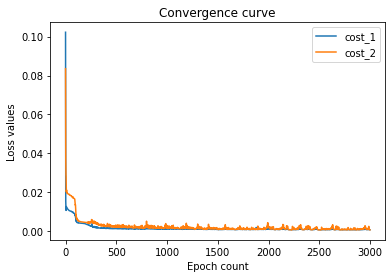

In [ ]:
plt.plot(range(num_epoch), np.mean(costs[:, :, 0], axis=1), label='cost_1')
plt.plot(range(num_epoch), np.mean(costs[:, :, 1], axis=1), label='cost_2')
plt.title('Convergence curve')
plt.xlabel('Epoch count')
plt.ylabel('Loss values')
plt.legend()
plt.show()

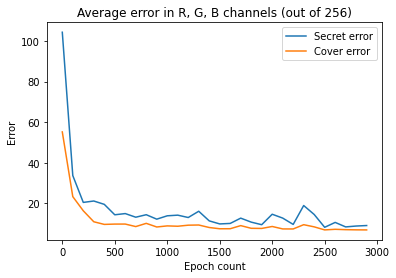

In [ ]:
plt.plot(np.arange(0, num_epoch, 100), np.mean(error[:, :, 0]*255, axis=1), label='Secret error')
plt.plot(np.arange(0, num_epoch, 100), np.mean(error[:, :, 1]*255, axis=1), label='Cover error')
plt.title('Average error in R, G, B channels (out of 256)')
plt.xlabel('Epoch count')
plt.ylabel('Error')
plt.legend()
plt.show()

In [ ]:
final_secret_error = np.mean(error[-1, :, 0]*255)
final_cover_error = np.mean(error[-1, :, 1]*255)
print("Training hidden error: {:.2f}, Training cover error: {:.2f}".format(final_secret_error, final_cover_error))

Training hidden error: 9.13, Training cover error: 6.97


In [ ]:
#jpegleri dataya atıyor

data_location2 = "./test/"
data_array2 = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location2)):
    for filename in fileList:
        if ".jpg" in filename.lower():  # check whether the file's DICOM
            data_array2.append(os.path.join(dirName,filename))

X2 = np.zeros(shape=(200,80,80,3))

for file_index in range(len(data_array2)):
    X2[file_index,:,:]   = imresize(imread(data_array2[file_index],mode='RGB'),(80,80))

for i in range(len(X2)):
    X2[i,:,:,0] = (X2[i,:,:,0]-X2[i,:,:,0].min(axis=0))/(X2[i,:,:,0].max(axis=0)-X2[i,:,:,0].min(axis=0))
    X2[i,:,:,1] = (X2[i,:,:,1]-X2[i,:,:,1].min(axis=0))/(X2[i,:,:,1].max(axis=0)-X2[i,:,:,1].min(axis=0))
    X2[i,:,:,2] = (X2[i,:,:,2]-X2[i,:,:,2].min(axis=0))/(X2[i,:,:,2].max(axis=0)-X2[i,:,:,2].min(axis=0))

half2 = len(X2)//2
s_images2 = X2[:half2,:,:,:]
c_images2 = X2[half2:,:,:,:]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  del sys.path[0]


INFO:tensorflow:Restoring parameters from ./my_model


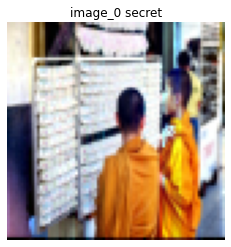

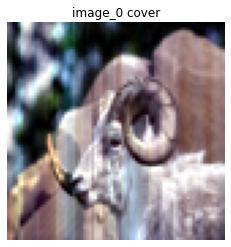

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


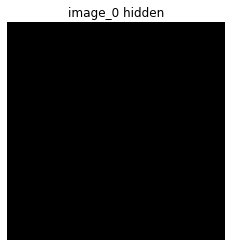

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


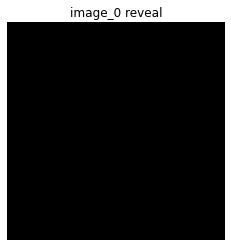

INFO:tensorflow:Restoring parameters from ./my_model


KeyboardInterrupt: ignored

In [ ]:
with tf.Session() as sess2:
    test_error = np.zeros((len(s_images2), 2))
  
    for i in range(len(s_images2)):
        new_saver = tf.train.import_meta_graph('my_model.meta')
        new_saver.restore(sess2, tf.train.latest_checkpoint('./'))
        #tf.initialize_all_variables().run(session=sess2)
        all_vars = tf.get_collection('vars')
        current_batch_s = np.expand_dims(s_images2[i,:,:,:],0)
        current_batch_c = np.expand_dims(c_images2[i,:,:,:],0)
        sess_results = sess2.run([prep_layer5,hide_layer6,reve_layer4],feed_dict={Secret:current_batch_s,Cover:current_batch_c})
        test_error[i][0], test_error[i][1] = get_error(s_images2[i,:,:,:], c_images2[i,:,:,:], np.squeeze(sess_results[1][0,:,:,:]), np.squeeze(sess_results[2][0,:,:,:]))

        plt.figure()
        plt.imshow(np.squeeze(current_batch_s[0,:,:,:]))
        plt.axis('off')
        plt.title('image_'+str(i)+' secret')
        plt.show()

        plt.figure()
        plt.imshow(np.squeeze(current_batch_c[0,:,:,:]))
        plt.axis('off')
        plt.title('image_'+str(i)+' cover')
        plt.show()

        # plt.figure()
        # plt.imshow(np.squeeze(sess_results[0][0,:,:,:]))
        # plt.axis('off')
        # plt.title('epoch_'+str(i)+' prep image')
        # plt.show()

        plt.figure()
        plt.imshow(np.squeeze(sess_results[1][0,:,:,:]))
        plt.axis('off')
        plt.title('image_'+str(i)+" hidden")
        plt.show()

        plt.figure()
        plt.axis('off')
        plt.imshow(np.squeeze(sess_results[2][0,:,:,:]))
        plt.title('image_'+str(i)+" reveal")
        plt.show()


In [ ]:
test_secret_error = np.mean(test_error[:, 0]*255)
test_cover_error = np.mean(test_error[:, 1]*255)
print("Test hidden error: {:.2f}, Test cover error: {:.2f}".format(test_secret_error, test_cover_error))

Test hidden error: 76.53, Test cover error: 78.95


In [ ]:
#gifi pngye ceviriyor klasoru kendin
import PIL

from PIL import Image

from PIL import GifImagePlugin

 

#imageObject = Image.open("tenor.gif")
num_key_frames = 23

with Image.open("tenor.gif") as im:
    for i in range(num_key_frames):
        im.seek(im.n_frames // num_key_frames * i)
        #im.convert('RGB')
        im.save('./deneme2/{}.png'.format(str(i).zfill(2)))
        

In [ ]:
#pngleri jpege çeviriyor
import cv2, os


def tif_to_jpeg_converter(filePath):
    base_path = filePath
    new_path = filePath
    for infile in os.listdir(base_path):
        # print("file : " + infile)
        read = cv2.imread(base_path + infile)
        outfile = infile.split('.')[0] + '.jpg'
        cv2.imwrite(new_path + outfile, read, [int(cv2.IMWRITE_JPEG_QUALITY), 200])
        # Deleting the .tiff file after converting
        if infile[-3:] == "png":
            print(infile)
            os.remove(filePath + '/' + infile)
            # check if file exists or not

tif_to_jpeg_converter("./deneme2/")

18.png
03.png
10.png
02.png
12.png
01.png
11.png
00.png
17.png
09.png
16.png
22.png
05.png
08.png
07.png
04.png
13.png
14.png
15.png
19.png
06.png
21.png
20.png


In [ ]:
#jpegleri dataya atıyor

data_location3 = "./deneme2/"
data_array3 = []  # create an empty list
for dirName, subdirList, fileList in os.walk(data_location3):
    for i in range(23):
        for filename in fileList:
            if ".jpg" in filename.lower():  # check whether the file's DICOM
                ind = int(filename[:2])
                if ind == len(data_array3):
                    data_array3.append(os.path.join(dirName,filename))
            

X3 = np.zeros(shape=(22,80,80,3))

for file_index in range(len(data_array3)-1):
    X3[file_index,:,:]   = imresize(imread(data_array3[file_index],mode='RGB'),(80,80))

for i in range(len(X3)):
    X3[i,:,:,0] = (X3[i,:,:,0]-X3[i,:,:,0].min(axis=0))/(X3[i,:,:,0].max(axis=0)-X3[i,:,:,0].min(axis=0))
    X3[i,:,:,1] = (X3[i,:,:,1]-X3[i,:,:,1].min(axis=0))/(X3[i,:,:,1].max(axis=0)-X3[i,:,:,1].min(axis=0))
    X3[i,:,:,2] = (X3[i,:,:,2]-X3[i,:,:,2].min(axis=0))/(X3[i,:,:,2].max(axis=0)-X3[i,:,:,2].min(axis=0))

half3 = len(X3)//2
s_images3 = X3[half3:,:,:,:]
c_images3 = X3[:half3,:,:,:]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


INFO:tensorflow:Restoring parameters from ./my_model


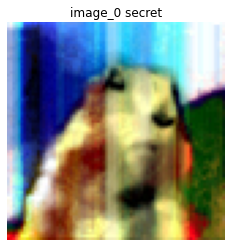

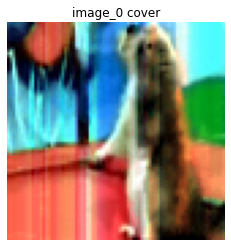

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


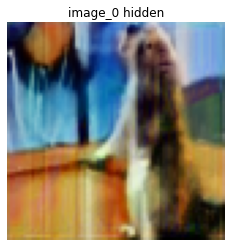

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


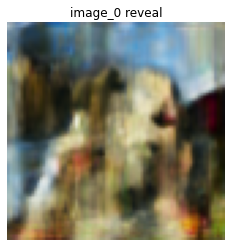

INFO:tensorflow:Restoring parameters from ./my_model


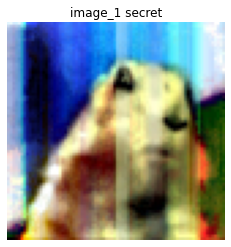

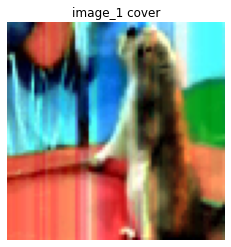

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


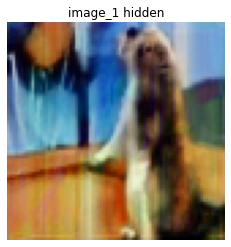

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


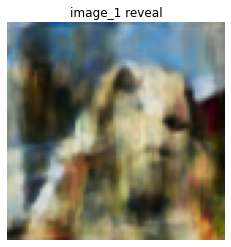

INFO:tensorflow:Restoring parameters from ./my_model


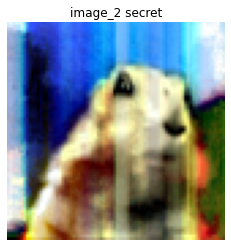

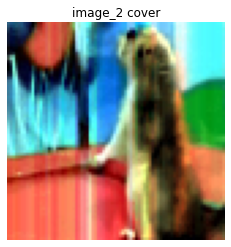

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


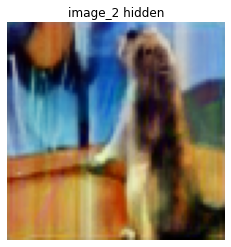

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


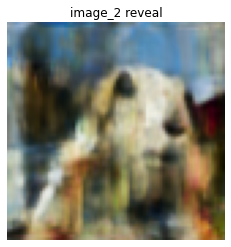

INFO:tensorflow:Restoring parameters from ./my_model


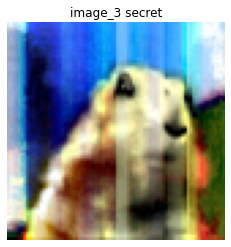

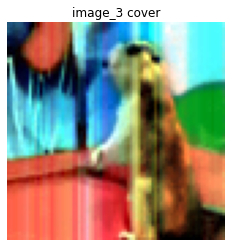

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


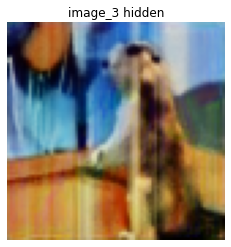

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


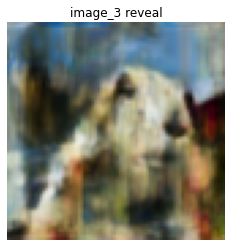

INFO:tensorflow:Restoring parameters from ./my_model


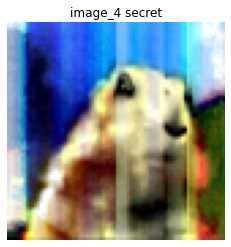

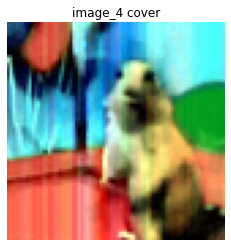

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


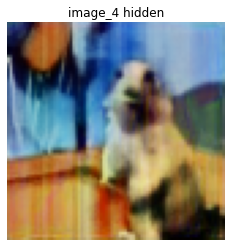

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


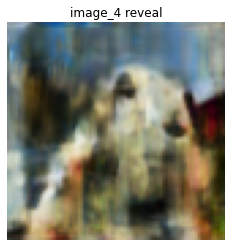

INFO:tensorflow:Restoring parameters from ./my_model


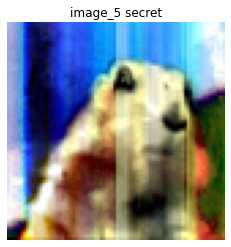

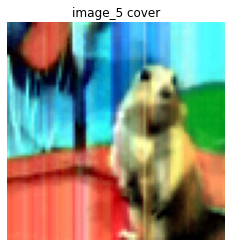

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


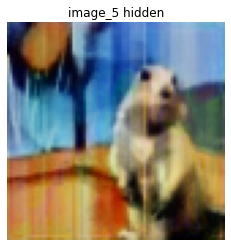

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


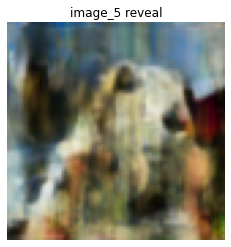

INFO:tensorflow:Restoring parameters from ./my_model


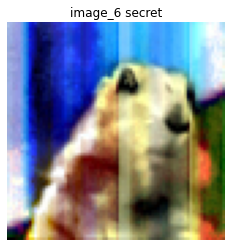

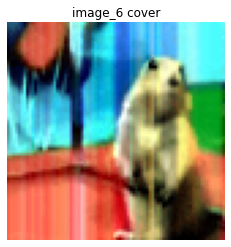

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


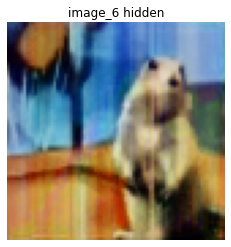

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


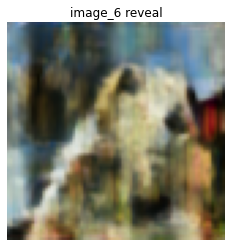

INFO:tensorflow:Restoring parameters from ./my_model


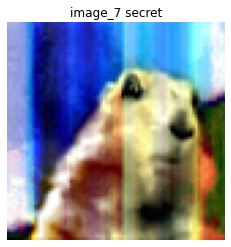

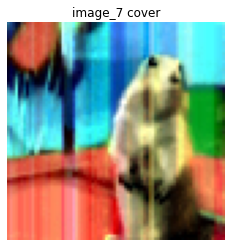

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


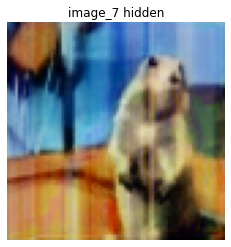

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


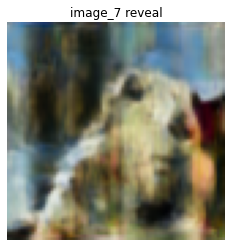

INFO:tensorflow:Restoring parameters from ./my_model


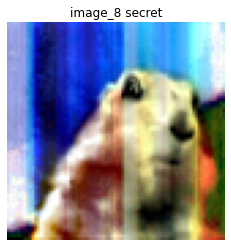

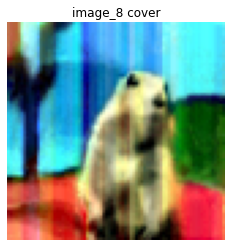

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


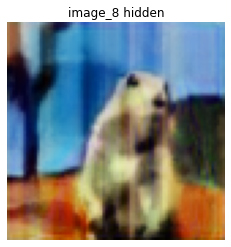

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


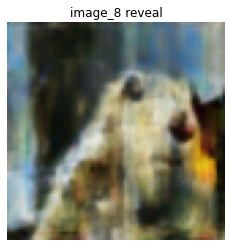

INFO:tensorflow:Restoring parameters from ./my_model


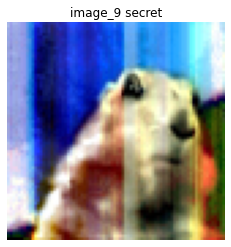

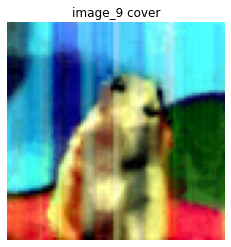

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


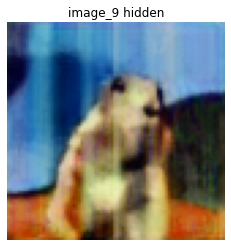

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


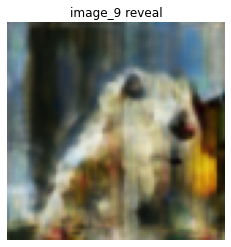

INFO:tensorflow:Restoring parameters from ./my_model


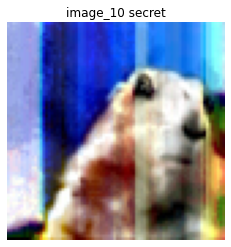

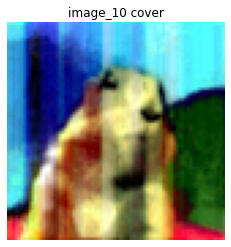

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


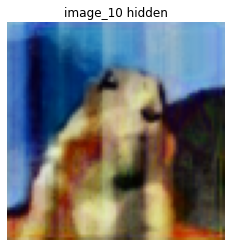

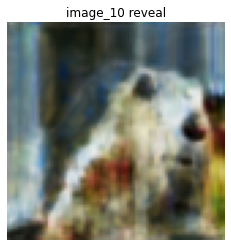

In [ ]:
with tf.Session() as sess3:
    gif_error = np.zeros((len(s_images3), 2))
    gif_hidden = []
    gif_reveal = []
  
    for i in range(len(s_images3)):
        new_saver = tf.train.import_meta_graph('my_model.meta')
        new_saver.restore(sess3, tf.train.latest_checkpoint('./'))
        #tf.initialize_all_variables().run(session=sess2)
        all_vars = tf.get_collection('vars')
        #random_data_index = np.random.randint(len(s_images))
        current_batch_s = np.expand_dims(s_images3[i,:,:,:],0)
        current_batch_c = np.expand_dims(c_images3[i,:,:,:],0)
        sess_results = sess3.run([prep_layer5,hide_layer6,reve_layer4],feed_dict={Secret:current_batch_s,Cover:current_batch_c})
        gif_error[i][0], gif_error[i][1] = get_error(s_images3[i,:,:,:], c_images3[i,:,:,:], np.squeeze(sess_results[1][0,:,:,:]), np.squeeze(sess_results[2][0,:,:,:]))
        gif_hidden.append(np.squeeze(sess_results[1][0,:,:,:]))
        gif_reveal.append(np.squeeze(sess_results[2][0,:,:,:]))

        plt.figure()
        plt.imshow(np.squeeze(current_batch_s[0,:,:,:]))
        plt.axis('off')
        plt.title('image_'+str(i)+' secret')
        plt.show()

        plt.figure()
        plt.imshow(np.squeeze(current_batch_c[0,:,:,:]))
        plt.axis('off')
        plt.title('image_'+str(i)+' cover')
        plt.show()

        # plt.figure()
        # plt.imshow(np.squeeze(sess_results[0][0,:,:,:]))
        # plt.axis('off')
        # plt.title('epoch_'+str(i)+' prep image')
        # plt.show()

        plt.figure()
        plt.imshow(np.squeeze(sess_results[1][0,:,:,:]))
        plt.axis('off')
        plt.title('image_'+str(i)+" hidden")
        plt.show()

        plt.figure()
        plt.axis('off')
        plt.imshow(np.squeeze(sess_results[2][0,:,:,:]))
        plt.title('image_'+str(i)+" reveal")
        plt.show()


In [ ]:
import numpy as np
frames = np.random.randint(256, size=[20, 64, 64, 1], dtype=np.uint8)  # YOUR DATA HERE

# save it as a gif
from moviepy.editor import ImageSequenceClip
clip = ImageSequenceClip(list(frames), fps=20)
clip.write_gif('test.gif', fps=20)


In [ ]:
#sess2 = tf.Session()
with tf.Session() as sess2:
  new_saver = tf.train.import_meta_graph('my-model.meta')
  new_saver.restore(sess2, tf.train.latest_checkpoint('/content/drive/MyDrive/modelim'))
  tf.initialize_all_variables().run(session=sess2)
  all_vars = tf.get_collection('vars')

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/modelim/my-model
Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [ ]:
with tf.Session() as sess:
  new_saver = tf.train.import_meta_graph('my-model2.meta')
  new_saver.restore(sess, "my-model2" )
  tf.initialize_all_variables().run(session=sess)